In [448]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn import tree

from holisticai.bias.plots import correlation_matrix_plot, abroca_plot
from holisticai.bias.metrics import classification_bias_metrics, abroca
from holisticai.efficacy.metrics import classification_efficacy_metrics

from holisticai.bias.mitigation import ExponentiatedGradientReduction, GridSearchReduction, MetaFairClassifier

from fairlearn.metrics import equalized_odds_difference, equalized_odds_ratio, demographic_parity_difference, demographic_parity_ratio

In [353]:
os.chdir('C:\\Users\\Zezulka\\Documents\\01_PhD\\030-Projects\\2023-01_ALMP_LTU\\')

df = pd.read_csv('data\\1203_ALMP_Sample_IATEs.csv')

df.head()

,Unnamed: 0,ID,age,canton_french,canton_german,canton_italian,canton_moth_tongue,city,city_big,city_medium,...,iapo_employment,iapo_personality,em_no_program,em_vocational,em_computer,em_language,em_job_search,em_employment,em_personality,risk_score_logistic
0,1,93554,25,0,1,0,0,1,0,0,...,0.393110,0.359668,0.808551,0.016848,0.015574,0.021930,0.110201,0.011252,0.015643,0.279635
1,2,94572,40,0,1,0,0,1,0,0,...,0.489198,0.445922,0.845888,0.009302,0.017941,0.018355,0.075317,0.021092,0.012104,0.535164
2,3,90068,40,0,1,0,0,1,0,0,...,0.423456,0.329749,0.783048,0.017716,0.012653,0.022841,0.093024,0.006736,0.063983,0.205901
3,4,39400,41,0,1,0,0,1,0,0,...,0.470486,0.384549,0.854665,0.014282,0.011965,0.022706,0.070771,0.013388,0.012222,0.428461
4,5,396,38,0,1,0,0,3,1,0,...,0.490702,0.409687,0.830483,0.014704,0.012593,0.021510,0.098877,0.010584,0.011249,0.621403


In [354]:
# Var list including all dummy categories.
risk_var_list = ["age","canton_moth_tongue","city_big","city_medium","city_no",
                   "emp_share_last_2yrs","emp_spells_5yrs",
                   "female","foreigner_b","foreigner_c","gdp_pc","married","other_mother_tongue","past_income",
                   "prev_job_manager","prev_job_sec_mis","prev_job_sec1","prev_job_sec2",
                   "prev_job_sec3","prev_job_self","prev_job_skilled","prev_job_unskilled",
                   "qual_semiskilled","qual_degree","qual_unskilled","qual_wo_degree",
                   "swiss","ue_spells_last_2yrs","unemp_rate"
                ]
'''
risk_var_list = ["age","canton_moth_tongue",
                 "city_medium","city_no",
                 "emp_share_last_2yrs","emp_spells_5yrs",
                 "female","foreigner_b","foreigner_c","gdp_pc","married","other_mother_tongue","past_income",
                 "prev_job_self", "prev_job_skilled","prev_job_unskilled",
                 "prev_job_sec2", "prev_job_sec3", "prev_job_sec_mis",
                 "qual_semiskilled","qual_unskilled","qual_wo_degree",
                 "swiss", "ue_spells_last_2yrs","unemp_rate"
                 ]
'''
risk_var_cont_list = ['age', 'emp_share_last_2yrs', 'emp_spells_5yrs', 
                      'gdp_pc', 'past_income', 'ue_spells_last_2yrs', 'unemp_rate'
                     ]
risk_var_binary_list = [x for x in risk_var_list if x not in risk_var_cont_list]

In [355]:
df[risk_var_list].describe()

,age,canton_moth_tongue,city_big,city_medium,city_no,emp_share_last_2yrs,emp_spells_5yrs,female,foreigner_b,foreigner_c,...,prev_job_self,prev_job_skilled,prev_job_unskilled,qual_semiskilled,qual_degree,qual_unskilled,qual_wo_degree,swiss,ue_spells_last_2yrs,unemp_rate
count,19291.000000,19291.000000,19291.000000,19291.000000,19291.000000,19291.000000,19291.000000,19291.000000,19291.000000,19291.000000,...,19291.000000,19291.000000,19291.000000,19291.000000,19291.000000,19291.000000,19291.000000,19291.000000,19291.000000,19291.000000
mean,36.745011,0.099269,0.195013,0.124359,0.680628,0.811019,1.151210,0.439220,0.132704,0.231196,...,0.005236,0.606552,0.286766,0.159349,0.586698,0.223420,0.030532,0.636100,0.546991,3.526455
std,8.708328,0.299031,0.396221,0.329999,0.466245,0.244197,1.413955,0.496305,0.339264,0.421608,...,0.072170,0.488527,0.452263,0.366011,0.492439,0.416548,0.172051,0.481133,1.194079,0.833437
min,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.800000
25%,29.000000,0.000000,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.900000
50%,36.000000,0.000000,0.000000,0.000000,1.000000,0.916667,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,3.200000
75%,43.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,4.400000
max,55.000000,1.000000,1.000000,1.000000,1.000000,1.000000,14.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,4.900000


In [356]:
df[risk_var_list].isna().sum(), df[risk_var_list].shape

(age                    0
 canton_moth_tongue     0
 city_big               0
 city_medium            0
 city_no                0
 emp_share_last_2yrs    0
 emp_spells_5yrs        0
 female                 0
 foreigner_b            0
 foreigner_c            0
 gdp_pc                 0
 married                0
 other_mother_tongue    0
 past_income            0
 prev_job_manager       0
 prev_job_sec_mis       0
 prev_job_sec1          0
 prev_job_sec2          0
 prev_job_sec3          0
 prev_job_self          0
 prev_job_skilled       0
 prev_job_unskilled     0
 qual_semiskilled       0
 qual_degree            0
 qual_unskilled         0
 qual_wo_degree         0
 swiss                  0
 ue_spells_last_2yrs    0
 unemp_rate             0
 dtype: int64,
 (19291, 29))

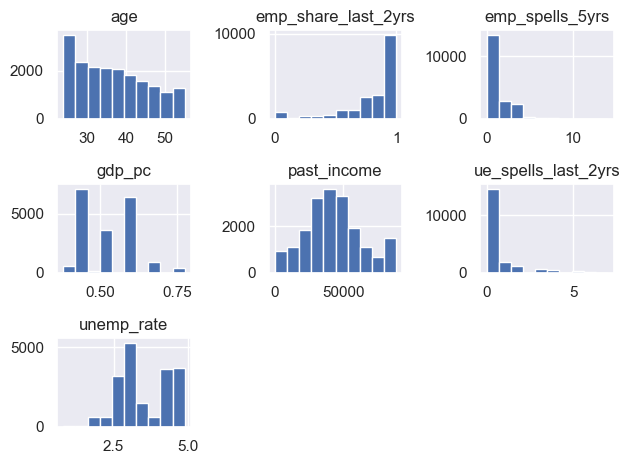

In [357]:
df[risk_var_cont_list].hist()
plt.tight_layout()
plt.show()

In [378]:
# prepare data
y = df['y_exit12']
X = df[risk_var_list]

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [379]:
print(X_train.shape)
print(X_test.shape)

(13503, 29)
(5788, 29)


In [380]:
# normalise continious train data 
X_train_binary = X_train[risk_var_binary_list]
X_train_cont = X_train[risk_var_cont_list]

X_test_binary = X_test[risk_var_binary_list]
X_test_cont = X_test[risk_var_cont_list]

# MinMax scaling of continious variables
scaler = MinMaxScaler()
X_train_cont = scaler.fit_transform(X_train_cont)
X_test_cont = scaler.transform(X_test_cont)


# make named DataFrames
X_train_cont = pd.DataFrame(X_train_cont, columns=risk_var_cont_list)
X_train_binary = pd.DataFrame(X_train_binary, columns=risk_var_binary_list).reset_index(drop=True)

X_test_cont = pd.DataFrame(X_test_cont, columns=risk_var_cont_list)
X_test_binary = pd.DataFrame(X_test_binary, columns=risk_var_binary_list).reset_index(drop=True)

df_X_train = pd.concat([X_train_cont, X_train_binary], axis=1)
df_X_test =  pd.concat([X_test_cont, X_test_binary], axis=1)


# group membership test
female_test = np.squeeze((X_test['female'] == 1).values)
male_test = np.squeeze((X_test['female'] == 0).values)

citizen_test = np.squeeze((X_test['swiss'] == 1).values)
non_citizen_test = np.squeeze((X_test['swiss'] == 0).values)

# group membership training
female_train = np.squeeze((X_train['female'] == 1).values)
male_train = np.squeeze((X_train['female'] == 0).values)

citizen_train = np.squeeze((X_train['swiss'] == 1).values)
non_citizen_train = np.squeeze((X_train['swiss'] == 0).values)

In [381]:
df_X_train.head()

,age,emp_share_last_2yrs,emp_spells_5yrs,gdp_pc,past_income,ue_spells_last_2yrs,unemp_rate,canton_moth_tongue,city_big,city_medium,...,prev_job_sec2,prev_job_sec3,prev_job_self,prev_job_skilled,prev_job_unskilled,qual_semiskilled,qual_degree,qual_unskilled,qual_wo_degree,swiss
0,0.483871,0.958333,0.142857,0.578491,0.476854,0.0,0.804878,0,0,0,...,0,0,0,1,0,0,1,0,0,1
1,0.741935,0.916667,0.142857,0.266893,0.358202,0.0,0.207317,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,0.354839,0.916667,0.142857,0.578491,0.337079,0.0,0.902439,0,1,0,...,0,1,0,0,1,0,0,1,0,0
3,0.709677,0.875000,0.071429,0.165585,0.915056,0.0,0.560976,0,0,0,...,0,1,0,1,0,0,1,0,0,1
4,0.096774,0.958333,0.071429,0.121082,0.438202,0.0,0.536585,0,0,1,...,0,1,0,1,0,0,1,0,0,1


In [452]:
df_X_test

,age,emp_share_last_2yrs,emp_spells_5yrs,gdp_pc,past_income,ue_spells_last_2yrs,unemp_rate,canton_moth_tongue,city_big,city_medium,...,prev_job_sec2,prev_job_sec3,prev_job_self,prev_job_skilled,prev_job_unskilled,qual_semiskilled,qual_degree,qual_unskilled,qual_wo_degree,swiss
0,0.483871,1.000000,0.000000,0.113585,0.410112,0.000000,0.463415,0,0,0,...,0,0,0,0,1,1,0,0,0,0
1,0.193548,0.916667,0.000000,0.163472,0.373034,0.000000,0.487805,0,0,0,...,0,1,0,1,0,0,1,0,0,1
2,0.387097,0.875000,0.142857,0.165585,0.450674,0.000000,0.560976,1,0,0,...,0,1,0,1,0,0,0,1,0,0
3,0.483871,0.750000,0.000000,0.042541,0.442247,0.000000,0.536585,0,0,0,...,1,0,0,1,0,0,1,0,0,1
4,0.709677,0.875000,0.214286,0.121082,0.403034,0.571429,0.536585,0,0,1,...,0,1,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5783,0.741935,0.541667,0.142857,0.368403,0.322135,0.142857,0.512195,0,0,0,...,0,0,0,0,1,0,0,1,0,0
5784,0.193548,1.000000,0.071429,0.121082,0.489326,0.285714,0.609756,0,0,0,...,0,1,0,0,1,0,0,1,0,0
5785,0.193548,0.541667,0.142857,0.121082,0.169438,0.571429,0.536585,0,0,0,...,0,0,0,0,1,0,0,1,0,0
5786,0.000000,1.000000,0.071429,0.578491,0.473258,0.000000,0.878049,0,1,0,...,0,1,0,1,0,0,1,0,0,1


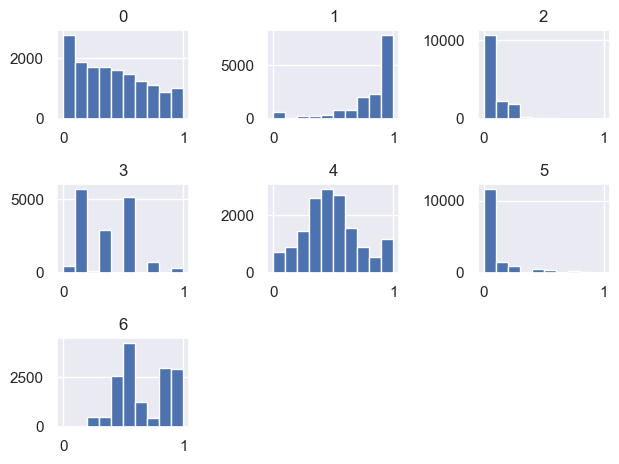

In [363]:
pd.DataFrame(X_cont).hist()
plt.tight_layout()
plt.show()

# Baseline: logistic regression

In [393]:
# Create a logistic regression model
logreg = LogisticRegression()
logreg = logreg.fit(df_X_train, y_train)

y_pred_logreg = logreg.predict(df_X_test)
y_proba_logreg = logreg.predict_proba(df_X_test)
y_score_logreg = y_proba_logreg[:,1]

In [376]:
pd.DataFrame(logreg.coef_, columns=df_X_train.columns).T

,0
age,1.219436
emp_share_last_2yrs,-0.766103
emp_spells_5yrs,-0.042495
gdp_pc,0.749259
past_income,-1.128644
ue_spells_last_2yrs,0.563362
unemp_rate,-0.418447
canton_moth_tongue,-0.067570
city_big,0.003111
city_medium,0.060234


In [300]:
# Decision Trees
clf = tree.DecisionTreeClassifier(random_state=1)
# clf = clf.fit(df_X_train, y_train)

cross_val_score(clf, df_X_train, y_train, cv=10)
# y_proba_tree = clf.predict_proba(df_X_test)
# y_score_tree = y_proba_tree[:,1]
# y_pred_tree = clf.predict(df_X_test)

array([0.5738342 , 0.54727979, 0.56124433, 0.55346727, 0.55152301,
       0.56448477, 0.58327933, 0.53920933, 0.573558  , 0.57874271])

(array([[1.698e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 2.159e+03],
        [2.159e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 1.698e+03]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 2 BarContainer objects>)

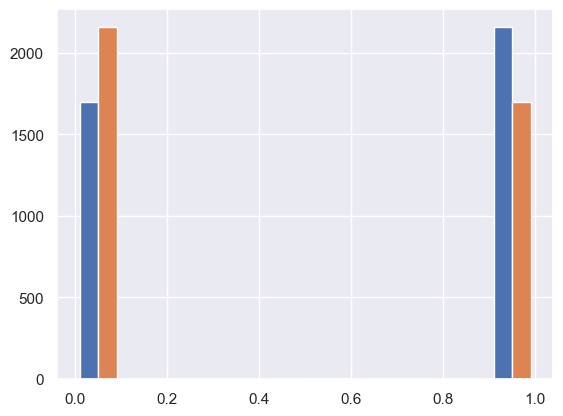

In [297]:
plt.hist(y_proba_tree)

In [368]:
df.groupby(['female'])['y_exit12'].mean()
# df.groupby(['swiss'])['y_exit12'].mean()

# df.groupby(['female', 'swiss'])['y_exit12'].mean()

female
0    0.403956
1    0.442464
Name: y_exit12, dtype: float64

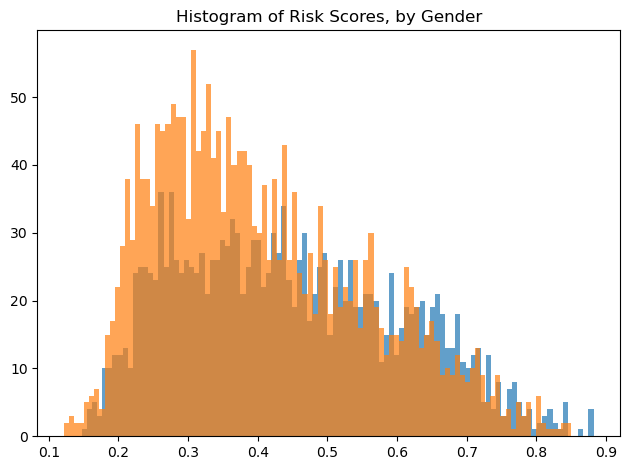

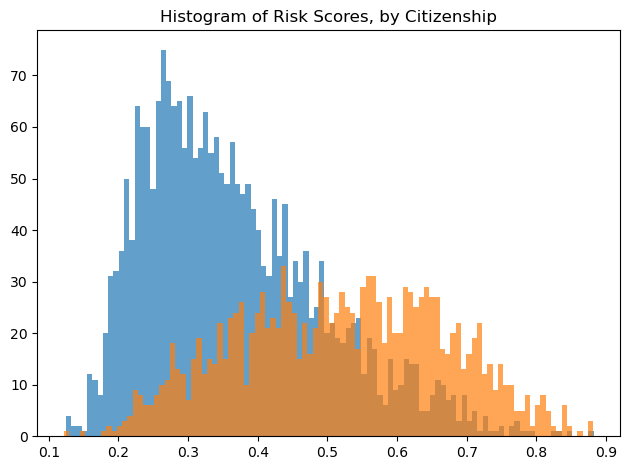

In [271]:
df_test = df.iloc[X_test.index]
y_score_old = df_test['risk_score_logistic']

plt.hist(y_score_old[X_test['female']==1], bins=100, alpha=0.7)
plt.hist(y_score_old[X_test['female']==0], bins=100, alpha=0.7)
plt.title("Histogram of Risk Scores, by Gender")
plt.tight_layout()
plt.show()

plt.hist(y_score_old[X_test['swiss']==1], bins=100, alpha=0.7)
plt.hist(y_score_old[X_test['swiss']==0], bins=100, alpha=0.7)
plt.title("Histogram of Risk Scores, by Citizenship")

plt.tight_layout()
plt.show()

In [435]:
classification_efficacy_metrics(y_pred_logreg, y_test)

,Value,Reference
Metric,,
Accuracy,0.640117,1
Balanced Accuracy,0.630717,1
Precision,0.431827,1
Recall,0.606979,1
F1-Score,0.504637,1


In [425]:
print(demographic_parity_difference(y_test, y_pred_logreg, sensitive_features=female_test))
print(demographic_parity_ratio(y_test, y_pred_logreg, sensitive_features=female_test))

# does not meet 4/5, 80% rule

# estimate both true positive and false positive rate differences, report larger ones
print(equalized_odds_difference(y_test, y_pred_logreg, sensitive_features=df_X_test['female']))
print(equalized_odds_ratio(y_test, y_pred_logreg, sensitive_features=female_test))

# equal opportunity as relaxed version of equalized odds, only conditioning on positive labels, Y=1

0.0847432431447705
0.7577939997292484
0.12155257612769688
0.75539419865661


In [384]:
# bias metrics
df_baseline = classification_bias_metrics(
    male_test,
    female_test,
    y_pred_logreg,
    y_test,
    metric_type='both'
)
df_baseline = df_baseline.copy()
df_baseline

,Value,Reference
Metric,,
Statistical Parity,-0.084743,0
Disparate Impact,0.757794,1
Four Fifths Rule,0.757794,1
Cohen D,-0.185353,0
2SD Rule,-6.961610,0
Equality of Opportunity Difference,-0.121553,0
False Positive Rate Difference,-0.037141,0
Average Odds Difference,-0.079347,0
Accuracy Difference,-0.012783,0


-0.02905421658934315


<Axes: xlabel='fpr', ylabel='tpr'>

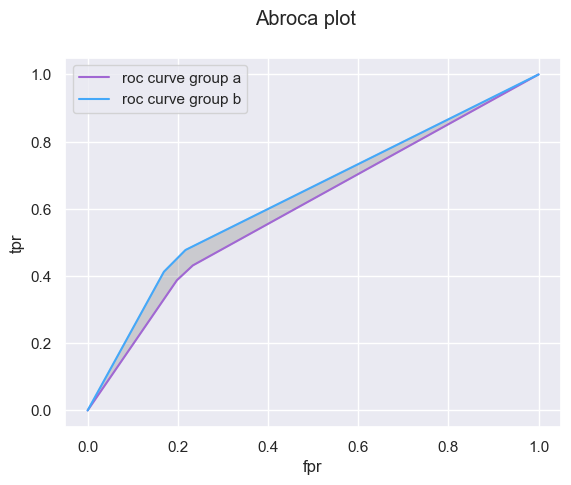

In [439]:
print(abroca(male_test, female_test, y_score_logreg, y_test))

abroca_plot(male_test, female_test, y_score_egr_dp, y_test)

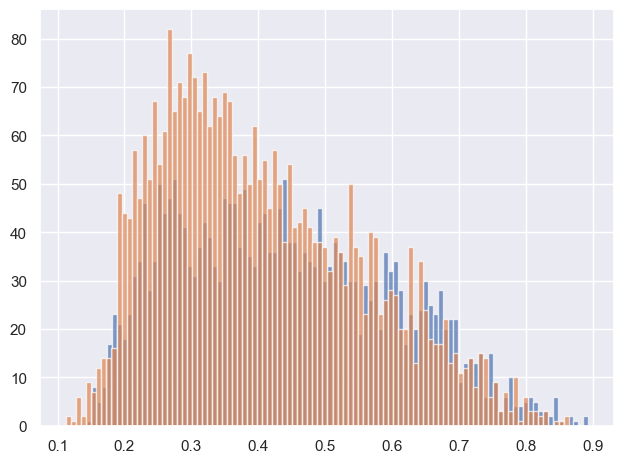

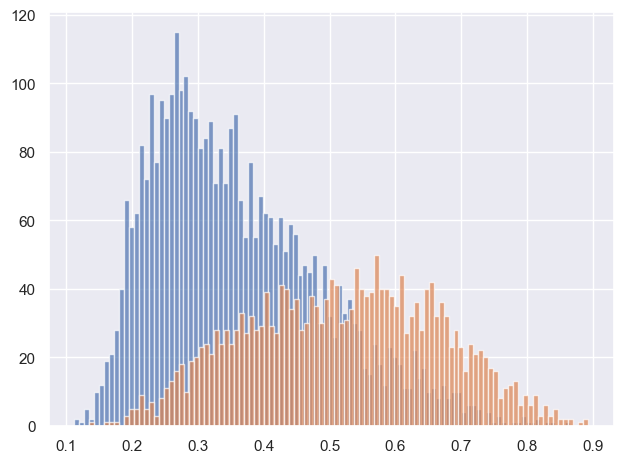

In [395]:
plt.hist(y_score_logreg[X_test['female']==1], bins=100, alpha=0.7)
plt.hist(y_score_logreg[X_test['female']==0], bins=100, alpha=0.7)

plt.tight_layout()
plt.show()

plt.hist(y_score_logreg[X_test['swiss']==1], bins=100, alpha=0.7)
plt.hist(y_score_logreg[X_test['swiss']==0], bins=100, alpha=0.7)

plt.tight_layout()
plt.show()

# Expo Gradient Reduction

In [428]:
# “DemographicParity”, “EqualizedOdds”, “TruePositiveRateParity”, “FalsePositiveRateParity”, “ErrorRateParity”,

logreg_egr_dp = ExponentiatedGradientReduction(
    estimator = LogisticRegression(),
    eps = 0.05,
    constraints="DemographicParity",
    )

logreg_egr_dp.fit(df_X_train, y_train, male_train, female_train)

y_pred_egr_dp = logreg_egr_dp.predict(df_X_test)
y_proba_egr_dp = logreg_egr_dp.predict_proba(df_X_test)
y_score_egr_dp = y_proba_egr_dp[:,1]

df_exp_grad = classification_bias_metrics(
    male_test,
    female_test,
    y_pred_egr_dp,
    y_test,
    metric_type='both'
)
df_exp_grad

C:\Users\Zezulka\Anaconda3\envs\2023-01-ALMP-LTU\Lib\site-packages\holisticai\bias\mitigation\inprocessing\exponentiated_gradient\_lagrangian.py:187: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  h_error = self.obj.gamma(h)[0]
C:\Users\Zezulka\Anaconda3\envs\2023-01-ALMP-LTU\Lib\site-packages\holisticai\bias\mitigation\inprocessing\exponentiated_gradient\_lagrangian.py:187: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  h_error = self.obj.gamma(h)[0]
C:\Users\Zezulka\Anaconda3\envs\2023-01-ALMP-LTU\Lib\site-packages\holisticai\bias\mitigation\inprocessing\exponentiated_gradient\_lagrangian.py:187: FutureWarning: Serie

,Value,Reference
Metric,,
Statistical Parity,-0.010417,0
Disparate Impact,0.965801,1
Four Fifths Rule,0.965801,1
Cohen D,-0.022762,0
2SD Rule,-0.858442,0
Equality of Opportunity Difference,-0.028871,0
False Positive Rate Difference,0.023008,0
Average Odds Difference,-0.002931,0
Accuracy Difference,-0.006734,0


In [436]:
classification_efficacy_metrics(y_pred_egr_dp, y_test)

,Value,Reference
Metric,,
Accuracy,0.637180,1
Balanced Accuracy,0.627439,1
Precision,0.424501,1
Recall,0.603239,1
F1-Score,0.498328,1


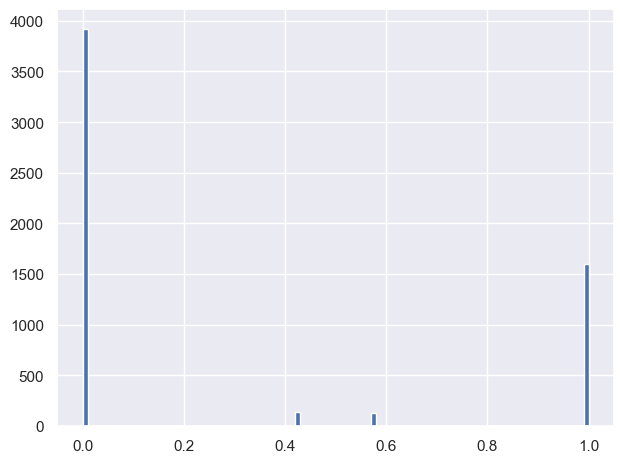

In [429]:
plt.hist(y_score_egr_dp, bins=100)
plt.tight_layout()

plt.show()

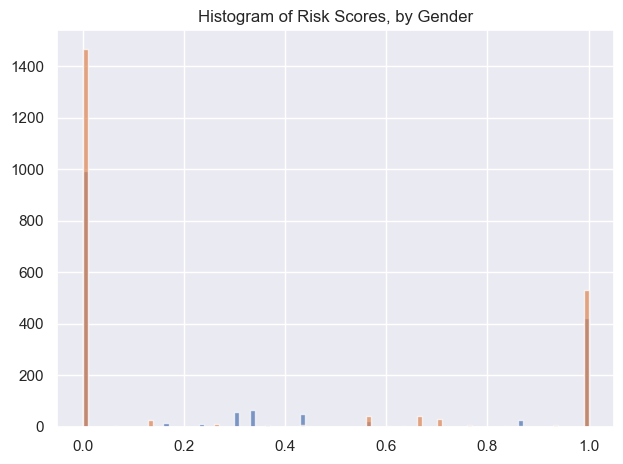

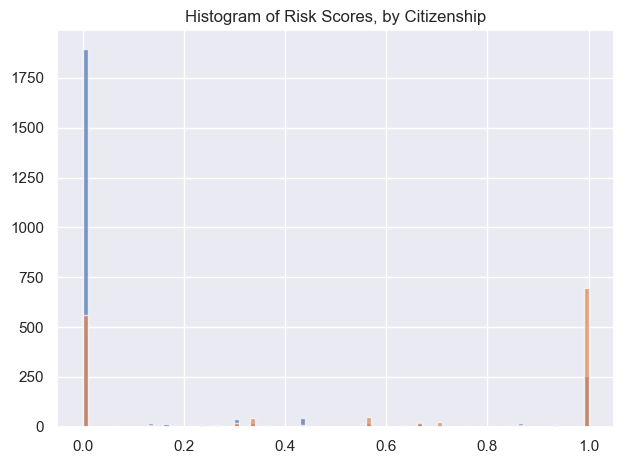

In [351]:
plt.hist(y_score_egr_dp[X_test['female']==1], bins=100, alpha=0.7)
plt.hist(y_score_egr_dp[X_test['female']==0], bins=100, alpha=0.7)
plt.title("Histogram of Risk Scores, by Gender")
plt.tight_layout()
plt.show()

plt.hist(y_score_egr_dp[X_test['swiss']==1], bins=100, alpha=0.7)
plt.hist(y_score_egr_dp[X_test['swiss']==0], bins=100, alpha=0.7)
plt.title("Histogram of Risk Scores, by Citizenship")

plt.tight_layout()
plt.show()

# Grid Search Reduction

In [453]:
# Define hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced'), param_grid=param_grid, scoring='accuracy', cv=5)

# Fit the grid search to the data
grid_search.fit(df_X_train, y_train)

# Get the best parameters and the best model
best_params_rf = grid_search.best_params_
best_model_rf = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_rf = best_model_rf.predict(df_X_test)
y_proba_rf = best_model_rf.predict_proba(df_X_test)
y_score_rf = y_proba_rf[:,1]
print(accuracy_score(y_test, y_pred_rf))

classification_efficacy_metrics(y_pred_rf, y_test)

0.6416724257083621


,Value,Reference
Metric,,
Accuracy,0.641672,1
Balanced Accuracy,0.631564,1
Precision,0.454212,1
Recall,0.603569,1
F1-Score,0.518346,1


In [457]:
best_params_rf

{'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 100}

In [454]:
classification_bias_metrics(
    male_test,
    female_test,
    y_pred_rf,
    y_test,
    metric_type='both'
)

,Value,Reference
Metric,,
Statistical Parity,-0.097439,0
Disparate Impact,0.739817,1
Four Fifths Rule,0.739817,1
Cohen D,-0.210109,0
2SD Rule,-7.882046,0
Equality of Opportunity Difference,-0.135394,0
False Positive Rate Difference,-0.048264,0
Average Odds Difference,-0.091829,0
Accuracy Difference,-0.014248,0


In [455]:
# “DemographicParity”, “EqualizedOdds”, “TruePositiveRateParity”, “FalsePositiveRateParity”, “ErrorRateParity”,
# model = RandomForestClassifier()
gsr = GridSearchReduction(constraints="DemographicParity",
                          constraint_weight=0.5
                         ).transform_estimator(best_model_rf)

gsr.fit(df_X_train, y_train, male_train, female_train)

y_pred_gsr_dp = gsr.predict(df_X_test)
y_proba_gsr_dp = gsr.predict_proba(df_X_test)
y_score_gsr_dp = y_proba_gsr_dp[:,1]

df_gsr_test = classification_bias_metrics(
    male_test,
    female_test,
    y_pred_gsr_dp,
    y_test,
    metric_type='both'
)
df_gsr_test

C:\Users\Zezulka\Anaconda3\envs\2023-01-ALMP-LTU\Lib\site-packages\holisticai\bias\mitigation\inprocessing\grid_search\algorithm.py:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  objective_ = self.objective.gamma(predict_fn)[0]
C:\Users\Zezulka\Anaconda3\envs\2023-01-ALMP-LTU\Lib\site-packages\holisticai\bias\mitigation\inprocessing\grid_search\algorithm.py:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  objective_ = self.objective.gamma(predict_fn)[0]
C:\Users\Zezulka\Anaconda3\envs\2023-01-ALMP-LTU\Lib\site-packages\holisticai\bias\mitigation\inprocessing\grid_search\algorithm.py:124: FutureWarning: Series._

,Value,Reference
Metric,,
Statistical Parity,-0.097289,0
Disparate Impact,0.738835,1
Four Fifths Rule,0.738835,1
Cohen D,-0.210118,0
2SD Rule,-7.882360,0
Equality of Opportunity Difference,-0.124522,0
False Positive Rate Difference,-0.055297,0
Average Odds Difference,-0.089910,0
Accuracy Difference,-0.005471,0


In [442]:
classification_efficacy_metrics(y_pred_gsr_dp, y_test)

,Value,Reference
Metric,,
Accuracy,0.635798,1
Balanced Accuracy,0.624680,1
Precision,0.452177,1
Recall,0.593166,1
F1-Score,0.513164,1


In [406]:
result = pd.concat([df_baseline, df_gsr_test, df_gsr_test_02,df_gsr_test_03], axis=1).iloc[:, [0,2,4,6,1]]
result.columns = ['Baseline','Grid Search, 0.5','Grid Search, 0.2','Grid Search, 0.9','Reference']
result

,Baseline,"Grid Search, 0.5","Grid Search, 0.2","Grid Search, 0.9",Reference
Metric,,,,,
Statistical Parity,-0.084743,-0.084743,-0.084743,-0.084743,0
Disparate Impact,0.757794,0.757794,0.757794,0.757794,1
Four Fifths Rule,0.757794,0.757794,0.757794,0.757794,1
Cohen D,-0.185353,-0.185353,-0.185353,-0.185353,0
2SD Rule,-6.961610,-6.961610,-6.961610,-6.961610,0
Equality of Opportunity Difference,-0.121553,-0.121553,-0.121553,-0.121553,0
False Positive Rate Difference,-0.037141,-0.037141,-0.037141,-0.037141,0
Average Odds Difference,-0.079347,-0.079347,-0.079347,-0.079347,0
Accuracy Difference,-0.012783,-0.012783,-0.012783,-0.012783,0


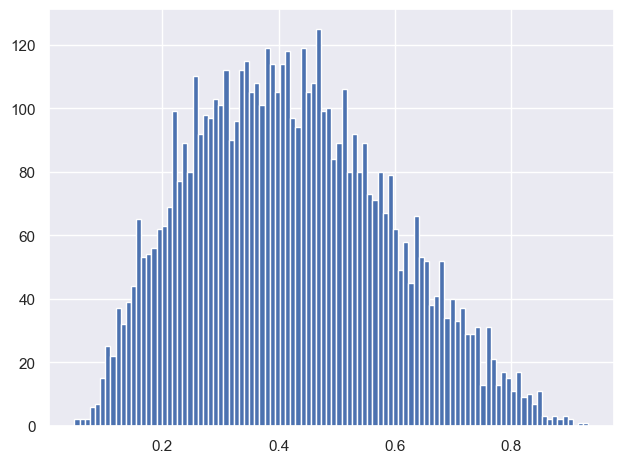

In [456]:
plt.hist(y_score_gsr_dp, bins=100)
plt.tight_layout()
plt.show()

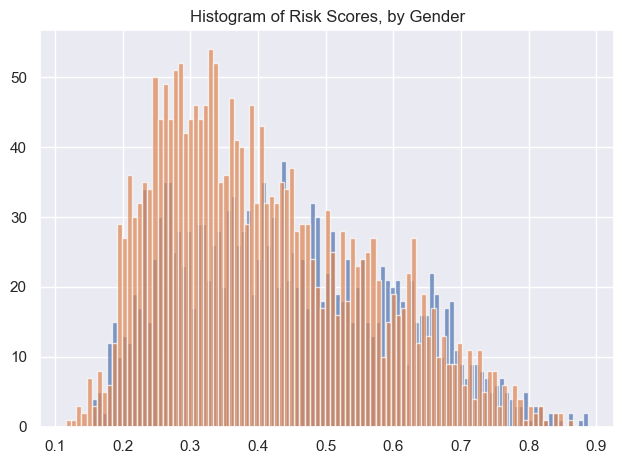

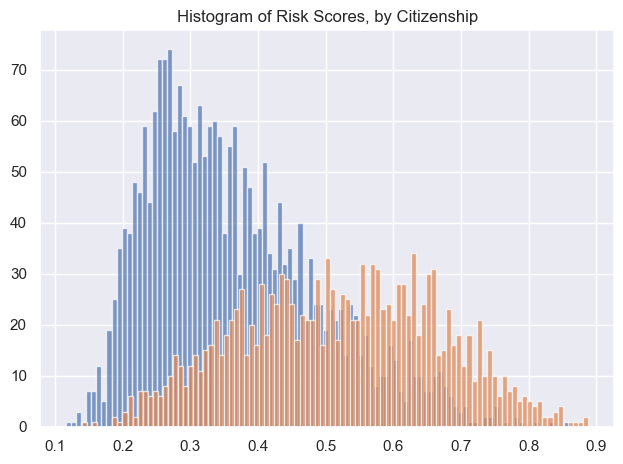

In [350]:
plt.hist(y_score_gsr_dp[X_test['female']==1], bins=100, alpha=0.7)
plt.hist(y_score_gsr_dp[X_test['female']==0], bins=100, alpha=0.7)
plt.title("Histogram of Risk Scores, by Gender")
plt.tight_layout()
plt.show()

plt.hist(y_score_gsr_dp[X_test['swiss']==1], bins=100, alpha=0.7)
plt.hist(y_score_gsr_dp[X_test['swiss']==0], bins=100, alpha=0.7)
plt.title("Histogram of Risk Scores, by Citizenship")

plt.tight_layout()
plt.show()

# Compare results

In [443]:
result = pd.concat([df_baseline, df_exp_grad, df_gsr_test], axis=1).iloc[:, [0,2,4,1]]
result.columns = ['Baseline','Ex Gradient','Grid Search','Reference']
result

,Baseline,Ex Gradient,Grid Search,Reference
Metric,,,,
Statistical Parity,-0.084743,-0.010417,-0.168830,0
Disparate Impact,0.757794,0.965801,0.597047,1
Four Fifths Rule,0.757794,0.965801,0.597047,1
Cohen D,-0.185353,-0.022762,-0.366783,0
2SD Rule,-6.961610,-0.858442,-13.610746,0
Equality of Opportunity Difference,-0.121553,-0.028871,-0.196464,0
False Positive Rate Difference,-0.037141,0.023008,-0.128747,0
Average Odds Difference,-0.079347,-0.002931,-0.162605,0
Accuracy Difference,-0.012783,-0.006734,0.004878,0


In [56]:




























# number of folds for cross-validation
num_folds = 5 

cv_predictions = cross_val_predict(logreg_model, X, y, cv=num_folds, method='predict_proba')

# Perform cross-validation
cross_val_scores = cross_val_score(logreg_model, X, y, cv=num_folds, scoring='accuracy')

# Display the cross-validation scores
print("Cross-Validation Scores:", cross_val_scores)
print("Mean Accuracy:", cross_val_scores.mean())

C:\Users\Zezulka\Anaconda3\envs\2023-01-ALMP-LTU\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Zezulka\Anaconda3\envs\2023-01-ALMP-LTU\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Zezulka\Anaconda3\envs\2023-01-ALMP-LTU\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Zezulka\Anaconda3\envs\2023-01-ALMP-LTU\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Zezulka\Anaconda3\envs\2023-01-ALMP-LTU\lib\site-packages\sklearn\linea

Cross-Validation Scores: [0.60507904 0.61466701 0.61327112 0.62078797 0.61083744]
Mean Accuracy: 0.6129285169201776


C:\Users\Zezulka\Anaconda3\envs\2023-01-ALMP-LTU\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Zezulka\Anaconda3\envs\2023-01-ALMP-LTU\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Zezulka\Anaconda3\envs\2023-01-ALMP-LTU\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Zezulka\Anaconda3\envs\2023-01-ALMP-LTU\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [57]:
cv_predictions[:,0]

array([0.66576007, 0.43423993, 0.77375757, ..., 0.63189132, 0.53430657,
       0.48445345])

In [277]:
plt.hist(cv_predictions[:,1], bins=100)
plt.show()

NameError: name 'cv_predictions' is not defined

In [65]:
cv_predictions.coef_()

AttributeError: 'numpy.ndarray' object has no attribute 'coef_'

In [ ]:
# parameter values for models